In [1]:
! pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 4.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.7/123.7 kB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 169.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 166.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 174.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 23.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 148.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 171.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 169.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7

  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4832 sha256=b4ae3cc3267d61b00b1291609e236bb91623fc4aec8a4995005152534f75343e
  Stored in directory: /home/gitpod/.cache/pip/wheels/a0/16/9c/5473df82468f958445479c59e784896fa24f4a5fc024b0f501
Successfully built termcolor
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.1
    Uninstalling protobuf-3.20.1:
      Successfully uninstalled protobuf-3.20.1
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 0.5.2
    Uninstalling google-auth-oauthlib-0.5.2:
      Successfully uninstalled google-auth-oauthlib-0.5.2


In [2]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import os
import matplotlib.pyplot as plt

## get data

In [3]:
class ArtificialData(object):
    """
    人口データを作成するクラス
    """

    def __init__(self, n_samples=100, noise_scale=.1):
        self.n_samples = n_samples
        self.noise_scale = noise_scale

    def true_function(self, x):
        """
        ノイズのない正しいデータを返す関数
        :param x:
        :return:
        :rtype: np.ndarray
        """
        raise NotImplementedError

    def make_x(self):
        return np.sort(np.random.uniform(-1.5, 1.5, size=self.n_samples)).astype(np.float32).reshape(-1, 1)

    def make_noise(self, x):
        return np.random.normal(loc=0, scale=self.noise_scale, size=x.shape)

    def generate(self):
        x = self.make_x()
        y = self.true_function(x)
        y += self.make_noise(y)
        return x, y

In [4]:
def func2(x):
    """
    人口データの正しい関数その2
    :param np.ndarray x:
    :return:
    :rtype: np.ndarray
    """
    return np.sin(5 * x) * np.abs(x)

In [5]:
class Art2(ArtificialData):
    def true_function(self, x):
        return func2(x)

    def make_x(self):
        x1 = np.random.uniform(-1.5, -.5, size=int(self.n_samples / 2))
        x2 = np.random.uniform(.5, 1.5, size=self.n_samples - x1.shape[0])
        x = np.vstack((x1, x2)).reshape(-1, 1)
        return np.sort(x)

In [6]:
def make_data(size, seed=1):
    """
    人工データの作成
    
    :param int size: 
    :param str function_type:
    :param int seed: 
    :return: データと正しい関数の集合
    :rtype: tuple[np.array, np.array, function]
    """
    np.random.seed(seed)
    x, y = Art2(size).generate()
    return x, y

In [7]:
x_test = None
x_train, y_train = make_data(size=100)

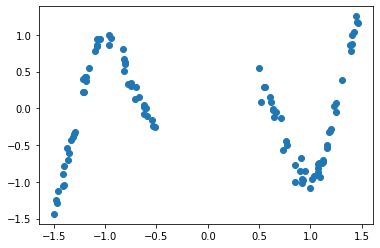

In [8]:
plt.scatter(x_train, y_train)

## Linear Deep Learning via Chainer

In [9]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Dropout, GaussianDropout
from tensorflow.keras.initializers import RandomNormal

2022-06-18 01:57:59.119063: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-18 01:57:59.119095: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [10]:
def build_model(input_dim, hidden_dim, p, activate="relu", mask="Dropout", apply_input=False, apply_hidden=True):
    inputs = keras.Input(shape=input_dim)
    inputs = eval(mask)(p)(inputs, training=apply_input)
    x = Dense(hidden_dim, activation="relu")(inputs)
    x = eval(mask)(p)(x, training=apply_hidden)
    x = keras.layers.Dense(hidden_dim, activation="relu")(x)
    x = eval(mask)(p)(x, training=apply_hidden)
    x = Dense(hidden_dim, activation="relu")(x)
    outputs = Dense(1)(x)

    model = keras.Model(inputs, outputs)

    model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error"])
    return model

## Bayes Part

In [11]:
class Transformer(object):
    """
    変数変換の実行クラス
    初めて変数が与えられたとき, 変換と同時にスケーリングのパラメータを学習し保存します。
    二回目以降は、一度目で学習したパラメータを用いて変換を行います。
    """

    def __init__(self, scaling=False):
        """
        コンストラクタ
        :param bool transform_log: 目的変数をログ変換するかのbool. 
        :param bool scaling: 
        """
        self._is_fitted = False
        self.scaling = scaling
        if scaling:
            self.scaler = StandardScaler()

    def _scaling(self, x):
        """

        :param np.ndarray x: 変換する変数配列
        :return: 
        :rtype: np.ndarray
        """
        shape = x.shape
        if len(shape) == 1:
            x = x.reshape(-1, 1)

        if self._is_fitted:
            x = self.scaler.transform(x)
        else:
            x = self.scaler.fit_transform(x)
            self._is_fitted = True
        x = x.reshape(shape)
        return x

    def transform(self, x):
        """
        目的変数のリストを受け取って変換器を作成し, 変換後の値を返す
        scaling変換 [-1,+1]

        :param np.ndarray x:
        :rtype: np.ndarray
        """
        x_trains = x[:]
        if self.scaling:
            x_trains = self._scaling(x)

        return x_trains

    def inverse_transform(self, x):
        """
        変換された値を元の値に逆変換
        :param x: np.ndarray
        :return: np.ndarray
        """
        x_inv = x[:]
        if self.scaling:
            x_inv = self.scaler.inverse_transform(x)

        return x_inv

In [12]:
def save_logloss(loss, name, save=True):
    """
    loss の epoch による変化を plot して保存.
    :param list loss: loss が格納されたリスト
    :param str name: ファイル名
    :param bool save: 保存するかどうかのフラグ. True のとき name で保存する.
    :return:
    """
    loss = np.array(loss)
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(111)
    ax1.plot(loss[:, 1], color="C0")
    ax1.set_yscale("log")
    if save:
        fig.savefig("{name}.png".format(**locals()), dpi=150)
    return

In [13]:
def preprocess(X, y=None):
    """
    入力変数の変換
    :param np.ndarray X:
    :param np.ndarray y:
    :return: 変換後の変数のタプル
    :rtype: tuple of (numpy.ndarray, numpy.ndarray)
    """
    x_transformed = x_transformer.transform(X)
    if y is None:
        return x_transformed

    y_transformed = y_transformer.transform(y)
    return x_transformed, y_transformed

def inverse_y_transform(y):
    """
    予測値の逆変換
    :param y: 
    :return: 
    """
    return y_transformer.inverse_transform(y)

def preprocess_array_format(x):
    """
     array の shape, 及び type をチェックして chainer に投げられるようにする.

    1. shapeの修正:
         (n_samples, ) -> (n_samples, 1)
    2. dtype の修正:
        int -> np.int32
        float -> np.float32

    :param np.ndarray x:
    :return:
    :rtype: np.ndarray
    """
    if len(x.shape) == 1:
        x = x.reshape(-1, 1)

    if np.issubdtype(x.dtype, np.integer):
        x = x.astype(np.int32)
    elif np.issubdtype(x.dtype, np.float):
        x = x.astype(np.float32)
    else:
        x = x.astype(np.float32)
    return x

In [14]:
def plot_posterior(x_test, x_train=None, y_train=None, n_samples=100):
    xx = np.linspace(-2.5, 2.5, 200).reshape(-1, 1)

    x_train, y_train = x_transformer.inverse_transform(x_train), inverse_y_transform(y_train)
    predict_values = posterior(xx, n=n_samples)

    predict_mean = predict_values.mean(axis=0)
    predict_var = predict_values.var(axis=0)

    fig = plt.figure(figsize=(6, 6))
    ax1 = fig.add_subplot(111)
    ax1.plot(x_train[:, 0], y_train[:, 0], "o", markersize=6., color="C0", label="Training Data Points",
             fillstyle="none")

    for i in range(100):
        if i == 0:
            ax1.plot(xx[:, 0], predict_values[i], color="C1", alpha=.1, label="Posterior Samples", linewidth=.5)
        else:
            ax1.plot(xx[:, 0], predict_values[i], color="C1", alpha=.1, linewidth=.5)

    ax1.plot(xx[:, 0], predict_mean, "--", color="C1", label="Posterior Mean")
    ax1.fill_between(xx[:, 0], predict_mean + predict_var, predict_mean - predict_var, color="C1",
                     label="1 $\sigma$", alpha=.5)

    ax1.set_ylim(-3.2, 3.2)
    ax1.set_xlim(min(xx), max(xx))
    ax1.legend(loc=4)
    return fig, ax1

def posterior(x, n=3):
    """
    :param np.ndarray x:
    :param int n: 
    :return:
    :rtype: np.ndarray
    """
    x = preprocess_array_format(x)
    x = preprocess(x)
    pred = [model(x).numpy().reshape(-1) for _ in range(n)]
    pred = inverse_y_transform(pred)
    pred = np.array(pred)
    return pred

In [15]:
apply_input = False
n_epoch = 1000
batch_size = 50
freq_print_loss=10
freq_plot=50
n_samples=100
data_name='art2'

In [16]:
model = build_model(x_train.shape[1], 512, 0.5, apply_input=apply_input)

2022-06-18 01:58:06.935571: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-18 01:58:06.935607: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-18 01:58:06.935626: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (eritsi-cicdstandard-dlgr1gnqxiz): /proc/driver/nvidia/version does not exist
2022-06-18 01:58:06.935794: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
output_dir = "data/{data_name}/".format(**locals())
# 画像の出力先作成
if os.path.exists(output_dir) is False:
    os.makedirs(output_dir)

In [18]:
x_transformer = Transformer(scaling=True)
y_transformer = Transformer(scaling=True)

X, y = preprocess(x_train, y_train)

N = X.shape[0]

model.compile(optimizer='adam', 
              loss='mean_squared_error', 
              metrics=['mean_squared_error'])

from sklearn.metrics import mean_squared_error

epoch: 0	loss:1.0012104456929831


/tmp/ipykernel_3993/1878039146.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif np.issubdtype(x.dtype, np.float):


epoch: 10	loss:1.0305611798864447
epoch: 20	loss:0.9457626032113288
epoch: 30	loss:0.9749589775851433
epoch: 40	loss:0.8770793418422876
epoch: 50	loss:0.6697539247537877


/tmp/ipykernel_3993/1878039146.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif np.issubdtype(x.dtype, np.float):


epoch: 60	loss:0.6149769953121972
epoch: 70	loss:0.5271446768034925
epoch: 80	loss:0.3057694310134562
epoch: 90	loss:0.20358903045631319
epoch: 100	loss:0.17301572610984817


/tmp/ipykernel_3993/1878039146.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif np.issubdtype(x.dtype, np.float):


epoch: 110	loss:0.12603978714695147
epoch: 120	loss:0.09249280373178612
epoch: 130	loss:0.1183998479262896
epoch: 140	loss:0.07510497895469938
epoch: 150	loss:0.07348356881601896


/tmp/ipykernel_3993/1878039146.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif np.issubdtype(x.dtype, np.float):


epoch: 160	loss:0.07739661665420884
epoch: 170	loss:0.08347225874120898
epoch: 180	loss:0.05701916738179505
epoch: 190	loss:0.06775106526289809
epoch: 200	loss:0.06417419975707517


/tmp/ipykernel_3993/1878039146.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif np.issubdtype(x.dtype, np.float):


epoch: 210	loss:0.05766487214020022
epoch: 220	loss:0.058419255281143785
epoch: 230	loss:0.07036142059650186
epoch: 240	loss:0.07365547320565545
epoch: 250	loss:0.07000238860200464


/tmp/ipykernel_3993/1878039146.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif np.issubdtype(x.dtype, np.float):


epoch: 260	loss:0.06384651134051966
epoch: 270	loss:0.06741298419701901
epoch: 280	loss:0.06045374271720792
epoch: 290	loss:0.07432347717471713
epoch: 300	loss:0.06363157942694554


/tmp/ipykernel_3993/1878039146.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif np.issubdtype(x.dtype, np.float):


epoch: 310	loss:0.05909006140478312
epoch: 320	loss:0.07195950168066448
epoch: 330	loss:0.054487082007189436
epoch: 340	loss:0.05047414292470787
epoch: 350	loss:0.05405355669173878


/tmp/ipykernel_3993/1878039146.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif np.issubdtype(x.dtype, np.float):


epoch: 360	loss:0.048658608187262226
epoch: 370	loss:0.052841713086560466
epoch: 380	loss:0.04747514488996659
epoch: 390	loss:0.0428138038989844
epoch: 400	loss:0.050014049732963396


/tmp/ipykernel_3993/1878039146.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif np.issubdtype(x.dtype, np.float):


epoch: 410	loss:0.05973457981060612
epoch: 420	loss:0.04596005166735507
epoch: 430	loss:0.05037756511112662
epoch: 440	loss:0.05378726533359082
epoch: 450	loss:0.03939375176141466


/tmp/ipykernel_3993/1878039146.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif np.issubdtype(x.dtype, np.float):


epoch: 460	loss:0.04506862176289075
epoch: 470	loss:0.04683788282617628
epoch: 480	loss:0.05225133345672527
epoch: 490	loss:0.05876011951061702
epoch: 500	loss:0.042122778493397135


/tmp/ipykernel_3993/1878039146.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif np.issubdtype(x.dtype, np.float):


epoch: 510	loss:0.05894955804817271
epoch: 520	loss:0.0480005782915611
epoch: 530	loss:0.05455806366639213
epoch: 540	loss:0.04191005645892717
epoch: 550	loss:0.04652473514205924


/tmp/ipykernel_3993/1878039146.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif np.issubdtype(x.dtype, np.float):


epoch: 560	loss:0.04776761343690453
epoch: 570	loss:0.04160564272020997
epoch: 580	loss:0.04579520356604217
epoch: 590	loss:0.0458903480318982
epoch: 600	loss:0.05837057237921969


/tmp/ipykernel_3993/1878039146.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif np.issubdtype(x.dtype, np.float):


epoch: 610	loss:0.05101124899115632
epoch: 620	loss:0.058966812175951525
epoch: 630	loss:0.052306610406796246
epoch: 640	loss:0.03774219178665119
epoch: 650	loss:0.05064235014884795


/tmp/ipykernel_3993/1878039146.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif np.issubdtype(x.dtype, np.float):


epoch: 660	loss:0.04048068043894062
epoch: 670	loss:0.038849122529463244
epoch: 680	loss:0.031920046261222426
epoch: 690	loss:0.04294929081309942
epoch: 700	loss:0.047849473600470906


/tmp/ipykernel_3993/1878039146.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif np.issubdtype(x.dtype, np.float):


epoch: 710	loss:0.034802284054402374
epoch: 720	loss:0.04141009653679331
epoch: 730	loss:0.03559945150793321
epoch: 740	loss:0.03740985802175454
epoch: 750	loss:0.0445277443359325


/tmp/ipykernel_3993/1878039146.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif np.issubdtype(x.dtype, np.float):


epoch: 760	loss:0.03655324044176373
epoch: 770	loss:0.05783441145837189
epoch: 780	loss:0.042254091946295515
epoch: 790	loss:0.0370937636066604
epoch: 800	loss:0.031653782843917


/tmp/ipykernel_3993/1878039146.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif np.issubdtype(x.dtype, np.float):


epoch: 810	loss:0.04090068066577778
epoch: 820	loss:0.042971200085447595
epoch: 830	loss:0.04251534498969645
epoch: 840	loss:0.04361661341848884
epoch: 850	loss:0.03880120433954739


/tmp/ipykernel_3993/1878039146.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif np.issubdtype(x.dtype, np.float):


epoch: 860	loss:0.04221137242961962
epoch: 870	loss:0.041939933778305905
epoch: 880	loss:0.0403270291461145
epoch: 890	loss:0.034660818758747235
epoch: 900	loss:0.04572249302070076


/tmp/ipykernel_3993/1878039146.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif np.issubdtype(x.dtype, np.float):


epoch: 910	loss:0.04035936582380634
epoch: 920	loss:0.03747355426234117
epoch: 930	loss:0.04157998301378209
epoch: 940	loss:0.031061473702131418
epoch: 950	loss:0.03268607409405961


/tmp/ipykernel_3993/1878039146.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif np.issubdtype(x.dtype, np.float):


epoch: 960	loss:0.036919729143509564
epoch: 970	loss:0.04022054680654514
epoch: 980	loss:0.04242299453150128
epoch: 990	loss:0.04859366846471515
epoch: 1000	loss:0.04025335845711697


/tmp/ipykernel_3993/1878039146.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif np.issubdtype(x.dtype, np.float):


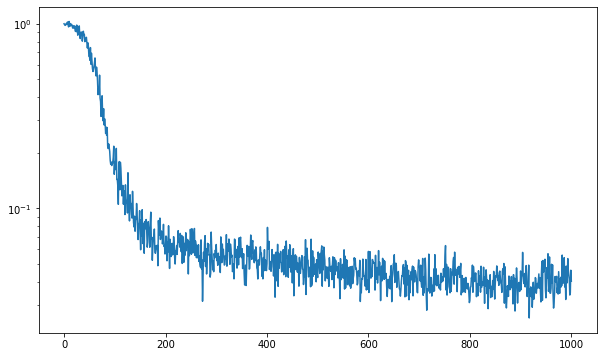

In [19]:
list_loss = []

for e in range(n_epoch+1):
    perm = np.random.permutation(N)
    for i in range(0, N, batch_size):
        idx = perm[i : i + batch_size]
        _x = X[idx]
        _y = y[idx]
        model.train_on_batch(_x, _y)

    y_pred = model(X)
    l = mean_squared_error(y, y_pred)
    
    if e % freq_print_loss == 0:
        print("epoch: {e}\tloss:{l}".format(**locals()))
    
    if e % freq_plot == 0:
        fig, ax = plot_posterior(x_test, X, y, n_samples=n_samples)
        ax.set_title("epoch:{0:04d}".format(e))
        fig.tight_layout()
        file_path = os.path.join(output_dir, "epoch={e:04d}.png".format(**locals()))
        fig.savefig(file_path, dpi=150)
        plt.close("all")
    list_loss.append([e, l])

save_logloss(list_loss, model.__str__())

In [20]:
from glob import glob
import os
from PIL import Image

def make_anime(files, name='anime'):
    images = list(map(lambda file : Image.open(file) , files))
    images[0].save(name+'.gif', save_all=True, \
        append_images=images[1:], optimize=True, duration=10 , loop=0)

l1_images = glob(os.path.join('./data/art2/',  "*.png"))
make_anime(l1_images, 'anime-keras')

keras version
<img src='./anime-keras.gif' width=400>
-
chainer version

<img src='./anime.gif' width=400></img>